In [2]:
import os
import sys
from dotenv import load_dotenv

load_dotenv()
PROJECT_PATH = os.environ.get('PROJECT_PATH')

# Add the project root path to sys.path
if PROJECT_PATH not in sys.path:
    sys.path.insert(0, PROJECT_PATH)

In [3]:

game_id = "0a22f881b77f00220f2034c21a18b854"
assets_path = os.path.join(PROJECT_PATH, 'data', 'Assets', game_id)


In [5]:
from PIL import Image, ImageEnhance
import cv2
import numpy as np

def load_image(image_path):
    return Image.open(image_path).convert('RGBA')

def adjust_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def resize_image(image, size):
    width, height = image.size
    aspect_ratio = width / height
    new_width, new_height = size
    if new_width / new_height > aspect_ratio:
        new_width = int(new_height * aspect_ratio)
    else:
        new_height = int(new_width / aspect_ratio)
    return image.resize((new_width, new_height))

def apply_saliency(image_path):
    image = cv2.imread(image_path)
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliency_map) = saliency.computeSaliency(image)
    saliency_map = (saliency_map * 255).astype("uint8")
    return saliency_map

def compose_ad_frame(frame_width: int, frame_height: int, elements: list, output_path: str = 'composed_image_frame.jpg') -> Image:
    """
    Composes an advertisement frame using multiple image elements.

    Args:
        frame_width (int): Width of the desired frame.
        frame_height (int): Height of the desired frame.
        elements (list): List of dictionaries, each containing:
            - image_path (str): Path to the image file.
            - position (tuple): (x, y) coordinates of the top-left corner.
            - size (tuple, optional): (width, height) to resize to (maintaining aspect ratio).
            - has_background (bool): Whether the image has a background (True) or is transparent (False).
            - brightness (float, optional): Brightness factor for the image.
            - z_index (int, optional): Layering order of the image.

    Returns:
        PIL.Image: The composed ad frame.
    """

    # Sort elements by z_index
    elements.sort(key=lambda x: x.get('z_index', 0))

    # Create a new blank RGBA image
    composed_frame = Image.new('RGBA', (frame_width, frame_height))

    for element in elements:
        # Load and convert image to RGBA
        img = load_image(element['image_path'])

        # Adjust brightness if specified
        if 'brightness' in element:
            img = adjust_brightness(img, element['brightness'])

        # Resize if size is provided
        if 'size' in element:
            img = resize_image(img, element['size'])

        # Paste the image onto the frame
        if element.get('has_background', True):  # Default to True if not specified
            composed_frame.paste(img, element['position'], img)
        else:
            composed_frame.alpha_composite(img, element['position'])

    # Convert to RGB
    new_img = composed_frame.convert('RGB')
    
    # Save the image
    new_img.save(output_path)
    
    return output_path

# Example usage:
elements = [
    {"image_path":  f"{assets_path}/header.jpg", "position": (0, 0), "brightness": 1.2, "z_index": 0},
    {"image_path": f"{assets_path}/engagement_instruction_1.png", "position": (40, 100), "has_background": False, "z_index": 1},
    {"image_path": f"{assets_path}/thumbnail.jpg", "position": (0, 200), "z_index": 0}
]

compose_ad_frame(600, 500, elements, 'composed_image_frame.jpg')


'composed_image_frame.jpg'

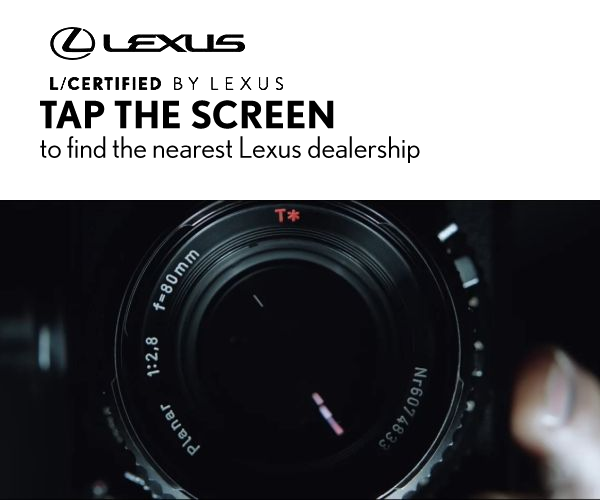

'composed_image_frame.jpg'

In [17]:
from PIL import Image, ImageEnhance
import numpy as np

def load_image(image_path):
    return Image.open(image_path).convert('RGBA')

def adjust_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def resize_image(image, size):
    width, height = image.size
    aspect_ratio = width / height
    new_width, new_height = size
    if new_width / new_height > aspect_ratio:
        new_width = int(new_height * aspect_ratio)
    else:
        new_height = int(new_width / aspect_ratio)
    return image.resize((new_width, new_height))

def compose_ad_frame(frame_width: int, frame_height: int, elements: list, output_path: str = 'composed_image_frame.jpg') -> Image:
    """
    Composes an advertisement frame using multiple image elements with advanced layering.

    Args:
        frame_width (int): Width of the desired frame.
        frame_height (int): Height of the desired frame.
        elements (list): List of dictionaries, each containing:
            - image_path (str): Path to the image file.
            - position (tuple): (x, y) coordinates of the top-left corner.
            - size (tuple, optional): (width, height) to resize to (maintaining aspect ratio).
            - has_background (bool): Whether the image has a background (True) or is transparent (False).
            - brightness (float, optional): Brightness factor for the image.
            - z_index (int): Layering order of the image, with a custom metric.
            - image_no (int): Unique identifier for the image.
            - layer (list of int, optional): List of image_nos to be placed on top of.

    Returns:
        PIL.Image: The composed ad frame.
    """

    # Initialize a dictionary to keep track of images by their image_no
    image_layers = {element['image_no']: element for element in elements}

    # Sort elements by z_index
    elements.sort(key=lambda x: x.get('z_index', 0))

    # Create a new blank RGBA image
    composed_frame = Image.new('RGBA', (frame_width, frame_height))

    for element in elements:
        # Load and convert image to RGBA
        img = load_image(element['image_path'])

        # Adjust brightness if specified
        if 'brightness' in element:
            img = adjust_brightness(img, element['brightness'])

        # Resize if size is provided
        if 'size' in element:
            img = resize_image(img, element['size'])

        # Handle layering
        if element.get('z_index', 0) == 0:  # Base level image
            composed_frame.paste(img, element['position'], img)
        else:  # Images with z_index > 0
            # Ensure base layers are present before pasting
            base_image = composed_frame.copy()
            if 'layer' in element:
                for layer_no in element['layer']:
                    layer_element = image_layers.get(layer_no)
                    if layer_element:
                        layer_img = load_image(layer_element['image_path'])
                        if 'brightness' in layer_element:
                            layer_img = adjust_brightness(layer_img, layer_element['brightness'])
                        if 'size' in layer_element:
                            layer_img = resize_image(layer_img, layer_element['size'])
                        base_image.paste(layer_img, layer_element['position'], layer_img)
            composed_frame.alpha_composite(img, element['position'])

    # Convert to RGB
    new_img = composed_frame.convert('RGB')
    
    new_img.show()
    
    # Save the image
    new_img.save(output_path)
    
    return output_path

# Example usage:
elements = [
    {"image_path": f"{assets_path}/header.jpg", "position": (0, 0), "image_no": 1, "brightness": 1.2, "z_index": 0},  # Base level
    {"image_path": f"{assets_path}/engagement_instruction_1.png", "position": (40, 100), "image_no": 2, "has_background": False, "z_index": 1, "layer": [1]},  # On top of z-index 1
    {"image_path": f"{assets_path}/thumbnail.jpg", "position": (0, 200), "image_no": 3, "z_index": 0}  # On top of z-index 3
]

compose_ad_frame(600, 500, elements, 'composed_image_frame.jpg')


#### Mean Color Calculation and Saliency features

In [5]:
import cv2
import numpy as np
from PIL import Image, ImageStat

def extract_image_features(image_path):
    image = cv2.imread(image_path)
    if not hasattr(cv2, 'saliency'):
        raise AttributeError("OpenCV installation does not include the saliency module.")
-
    # Compute saliency map
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    (success, saliency_map) = saliency.computeSaliency(image)
    saliency_map = (saliency_map * 255).astype("uint8")

    # Calculate mean color using PIL for RGB channels
    pil_image = Image.open(image_path).convert('RGB')
    stat = ImageStat.Stat(pil_image)
    mean_color = stat.mean

    return {
        "saliency_map": saliency_map,
        "mean_color": mean_color
    }

# Example usage:
# assets_path = "/path/to/assets"
features = extract_image_features(f"{assets_path}/_preview.png")
print("Saliency Map:", features["saliency_map"])
print("Mean Color:", features["mean_color"])


Saliency Map: [[ 6  6  6 ...  1  1  1]
 [ 6  6  6 ...  1  1  1]
 [ 6  6  6 ...  1  1  1]
 ...
 [ 1  1  1 ... 52 51 50]
 [ 0  0  0 ... 25 26 26]
 [ 0  0  0 ... 30 31 32]]
Mean Color: [106.83417666666666, 107.72758, 110.34306666666667]
